# Air Quality in Houston - Step 5: Model Application #



### Table of Contents

  *  [5.0. One Model, So Many Applications](#section5_0)

  *  [5.1. The Chosen Model, Its Parameters and Performance Metrics](#section5_1)

  *  [5.2. Modeling Trends](#section5_2)
         
  *  [5.3. The Final Conclusion](#section5_3)


<a class="anchor" id="section5_0"></a>
## 5.0. One Model, So Many Applications
The Notebook "04_Modeling" shows that the XGBoost Regressor model is the best one to model:
  *  The ozone concentration from pollutant data, weather data, traffic data and population data. (MAE 4.32 and RMSE 6.19).
  *  The ozone concentration from 5 pollutant concentrations (CO, NO2, SO2, PM 2.5, and PM 10) and the maximum temperature (MAE 2.15 and RMSE 4.55).
  *  The ozone concentration using only 1 pollutant, especially with PM 2.5 and NO2 (MAE 5.89 and RMSE 8.16).
  
The main features of importance are:
  *  Maximum outdoor temperature (ozone formation factor)
  *  Pollutants such PM 2.5, NO2, CO (ozone formation factor)
  *  Average windspeed and fastest windspeed (transport factor)
  
   
When comparing these main features to the ingredients involved in ground level ozone formation, which is summarized below in a simplified graph taken from Zhang et al.2019  [ https://www.frontiersin.org/articles/10.3389/fimmu.2019.02518/full], the model handles most ingredients besides the Volatile Organic Compounds (the data contains CO only) and sunlight.

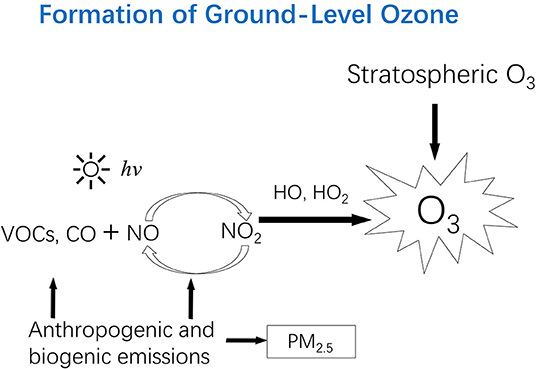

In [2]:
#print(model etrics for other pollutants)
from IPython.display import Image

Image(filename = "fimmu-10-02518-g001.jpg", width=500, height=300)

 Adding VOCs and UV data would have certainly benefitiated the model, however, the current results are satisfying.
 
 When it comes to applications the model can be applied to predicting ozone concentration from pollutant data and weather data as shown in 5.1., to predict the concentration of the 4 other pollutants as shown in the modeling, but it can also be used to get an idea of what the ozone concentration would be at higher temperature in the context of climate change as shown in 5.2.

<a class="anchor" id="section5_1"></a>
## 5.1. The Chosen Model, Its Parameters and Performance Metrics

Here are the parameters chosen to tune the XGBoost Regression model:
- boosting rounds:79,
- colsample_bytree & subsample: 1,
- max_depth: 20,
- learning rate (eta): 0.3.

The cross validation of the ozone model shows excellent results with a MAE of 5.8 ug/m3 and a RMSE of 8.1. The MAE is within the expected error measurement from common outdoor sensors which is typically 5 to 10 ug/m3. The model is described below and saved to file "aqh.pickle.dat" in the current folder.

In [3]:
### Import libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error
import pylab as pl
from IPython.display import Image
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import copy
import pickle
import math
import xgboost as xgb

### Location of dataframes and mapping files
path_header='C:\\Users\\Anne\\Documents\\GIT\\TheFoxerine\\'
path_df='CP2_AQ_HOUSTON\\00_SavedDataframes\\'
path_saf='CP2_AQ_HOUSTON\\00_StuffAndThings\\'
path_demog='CP2_AQ_HOUSTON\\00_OriginalData\\DEMOG\\'
path_eda='CP2_AQ_HOUSTON\\02_EDA\\'
path_feat='CP2_AQ_HOUSTON\\03_Feature\\'
path_mod='CP2_AQ_HOUSTON\\04_Modeling\\'

In [4]:
# Import Data
feat_files = {}
path_len=len(path_header+path_feat)
file_extension=len('.csv')

### glob fetches all xls files in the folder ###
allfiles = glob.glob(path_header+path_feat+'feat_*.csv')

### Because Python is all about dictionaries ;) ###
for filename in allfiles:
    df = pd.read_csv(filename,index_col=0)
    filename=filename[path_len::]
    filename_len=len(filename)
    filename=filename[0:(filename_len-file_extension)]
    key_name = str(filename)    
    feat_files[key_name] = copy.deepcopy(df)

### Let's unwrap all df with the correct name
for k,v in feat_files.items():
    globals()[f'{k}'] =v
    
### Let's look at one df, epa_co
feat_ozone.head()

,ozone,temp_max,dust_sand,rain_prcp,smoke_haze,thunder,fog_all,snow_all,rain_all,wind_avgspeed,...,month_November,month_October,month_September,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,39.0,57,0,0.0,0,0,0,0,0,21.03,...,0,0,0,0,0,0,0,0,1,0
9,38.0,50,0,0.0,0,0,0,0,0,18.34,...,0,0,0,0,0,0,0,0,0,1
18,37.0,51,0,0.0,0,0,0,0,0,10.74,...,0,0,0,0,0,0,0,1,0,0
27,35.0,65,0,0.0,0,0,1,1,1,14.54,...,0,0,0,1,0,0,0,0,0,0
36,37.0,71,0,0.0,0,0,1,1,1,10.51,...,0,0,0,0,0,1,0,0,0,0


In [5]:
onepoll=[feat_ozone,feat_co, feat_no2,feat_so2,feat_ozone, feat_pm10]

In [6]:
### create a function that split dataframes into sX,y and train/test sets
def TTS(df,colname):
    X=df.drop(columns=colname, inplace=False)
    y= df[[colname]]
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=13)
    return X,y,X_train,X_test,y_train,y_test

In [7]:
### train/test split
X_ozone, y_ozone, X_ozone_train, X_ozone_test, y_ozone_train, y_ozone_test=TTS(feat_ozone,'ozone')
X_co, y_co, X_co_train, X_co_test, y_co_train, y_co_test=TTS(feat_co,'co')
X_no2, y_no2, X_no2_train, X_no2_test, y_no2_train, y_no2_test=TTS(feat_no2,'no2')
X_so2, y_so2, X_so2_train, X_so2_test, y_so2_train, y_so2_test=TTS(feat_so2,'so2')
X_pm25, y_pm25, X_pm25_train, X_pm25_test, y_pm25_train, y_pm25_test=TTS(feat_pm25,'pm25')
X_pm10, y_pm10, X_pm10_train, X_pm10_test, y_pm10_train, y_pm10_test=TTS(feat_pm10,'pm10')

In [8]:
### scale X
ozone_scaler=RobustScaler()
X_ozone_train_scaled=ozone_scaler.fit_transform(X_ozone_train)
X_ozone_test_scaled=ozone_scaler.transform(X_ozone_test)

co_scaler=RobustScaler()
X_co_train_scaled=co_scaler.fit_transform(X_co_train)
X_co_test_scaled=co_scaler.transform(X_co_test)

no2_scaler=RobustScaler()
X_no2_train_scaled=no2_scaler.fit_transform(X_no2_train)
X_no2_test_scaled=no2_scaler.transform(X_no2_test)

so2_scaler=RobustScaler()
X_so2_train_scaled=so2_scaler.fit_transform(X_so2_train)
X_so2_test_scaled=so2_scaler.transform(X_so2_test)

pm25_scaler=RobustScaler()
X_pm25_train_scaled=pm25_scaler.fit_transform(X_pm25_train)
X_pm25_test_scaled=pm25_scaler.transform(X_pm25_test)

pm10_scaler=RobustScaler()
X_pm10_train_scaled=pm10_scaler.fit_transform(X_pm10_train)
X_pm10_test_scaled=pm10_scaler.transform(X_pm10_test)

In [9]:
### preparing DMatrix
ozone_dmx=xgb.DMatrix(data=X_ozone, label=y_ozone)
co_dmx=xgb.DMatrix(data=X_co, label=y_co)
no2_dmx=xgb.DMatrix(data=X_no2, label=y_no2)
so2_dmx=xgb.DMatrix(data=X_so2, label=y_so2)
pm25_dmx=xgb.DMatrix(data=X_pm25, label=y_pm25)
pm10_dmx=xgb.DMatrix(data=X_pm10, label=y_pm10)

In [10]:
tree_para_ozone = {'objective':'reg:squarederror','booster':'gbtree', 
             'n_estimators':1000, 'max_depth':20, 
             'colsample_bytree':1, 'subsample':1, 'eta':0.3}
nfold=10
boost=79
rmse_cv_ozone = xgb.cv(dtrain=ozone_dmx, params=tree_para_ozone , nfold=nfold, num_boost_round=boost, metrics='rmse', as_pandas=True, seed=13)
rmse_ozone=rmse_cv_ozone['test-rmse-mean'].tail().values[-1]
mae_cv_ozone= xgb.cv(dtrain=ozone_dmx, params=tree_para_ozone , nfold=nfold, num_boost_round=boost, metrics='mae', as_pandas=True, seed=13)
mae_ozone=mae_cv_ozone['test-mae-mean'].tail().values[-1]

[19:32:24] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:32:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:32:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in la

[19:38:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


O3 model MAE 4.32 and RMSE 6.19


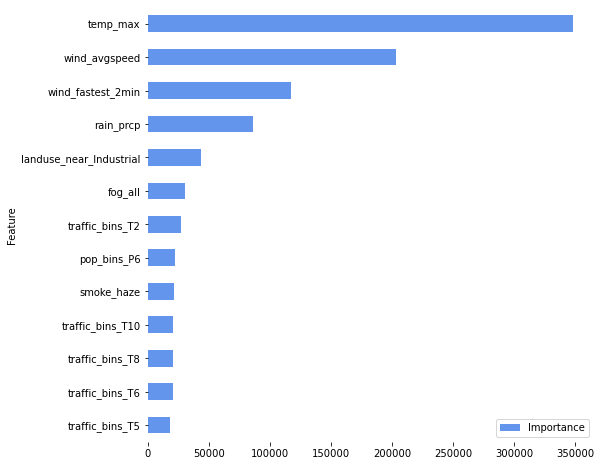

In [11]:
# Plot the feature importances
xgb_final_ozone = xgb.train(dtrain=ozone_dmx, params=tree_para_ozone , num_boost_round=100)
features_ozone = xgb_final_ozone.get_fscore()
impfeat_ozone = pd.DataFrame({'Importance': list(features_ozone.values()), 'Feature': list(features_ozone.keys())})
impfeat_ozone.sort_values(by = 'Importance', inplace = True, ascending = True)
impfeat_ozone.tail(13).plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'cornflowerblue')
sns.despine(top=True,bottom=True,right=True, left=True)
print('O3 model MAE',round(mae_ozone,2), 'and RMSE', round(rmse_ozone,2))

The chosen model has a MAE of 4.32 and RMSE of 6.19 which are within the measured error range.
The major features of importance of the ozone model are:
- the first feature is the maximum temperature, which is a catalyst in the formation of ozone.
- the second and third features are the wind, which transports the ozone away from its source and  is the reason why ozone can be found in remote country areas.
- the fourth feature is the amount of rain precipitation, which is interesting because rainy days tend to be less polluted because the pollutants are washed away by the rain. This phenomenon is called 'wet deposition'. Here the influence of rain will have to be determined: is it washing away pollution or washing it in?
- the fifth feature is industrial activity. Note that the pollution is not in the industrial zone, but 'near' it, which story works well with the influence of the  wind and the rain on ozone formation.

The minor features are a mix of foggy/hazy weather, traffic and population.

I performed the same type of parameters search for the other five pollutants and came up with the following parameters and results (the code can be found in section 04_Modeling):

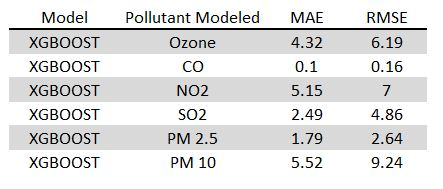

In [12]:
# show model metrics obtained for the other pollutants
Image(filename = "aqh_model_metrics.jpg", width=300, height=270)

Now let's apply the model and visualize the difference between test and predicted ozone concentrations.

In [13]:
xgb_ozone = xgb.XGBRegressor(colsample_bytree = 1, learning_rate = 0.3,max_depth = 20)

xgb_ozone.fit(X_ozone_train,y_ozone_train)

predicted_ozone = xgb_ozone.predict(X_ozone_test)

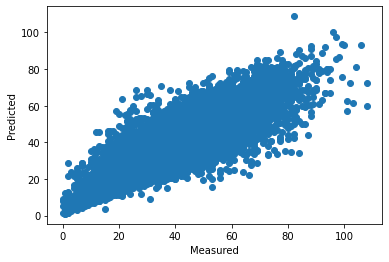

MAE: 4.6
RMSE: 6.5


In [14]:
fig, ax = plt.subplots()
ax.scatter(y_ozone_test, predicted_ozone)

ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

print('MAE:', round(mean_absolute_error(y_ozone_test, predicted_ozone),1))
print('RMSE:',round(np.sqrt(mean_squared_error(y_ozone_test, predicted_ozone)),1))

It does not look good but just as expected when considering the MAE and RMSE 

The model is saved using the pickle API.

In [15]:
# save model to file
pickle.dump(xgb_ozone, open("aqh.pickle.dat", "wb"))


<a class="anchor" id="section5_2"></a>
## 5.2. Modeling Trends
Climate change is a major threat the world has to comprehend and fight in this century and probably the next. What would be the impact of a change in climate on the formation of ozone in Houston? The three top features of importance are directly related to climate: maximum temperature, wind, and rain.
Let's find out what happens to the predictions of ozone concentrations when these three features decrease or increase.

In [16]:
# let's pretend the model does not already exist in this notebook ;)
## load model from file
aqh_model = pickle.load(open("aqh.pickle.dat", "rb"))

In [17]:
# decrease and increasse of temperature that will be added to the test data
increase_temp = [-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

# the wind will decrease down to 50% or increase up to the double of the test data
increase_wind = [0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]

# the rain will decrease down to 50% or increase up to the double of the test data
increase_rain = [0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]

temp_only_ozone_max_dict={}
temp_only_ozone_min_dict={}
temp_only_ozone_mean_dict={}

# prediction while changing the temperature
## I am adding or removing 1F at a time to the test data
for inctemp in increase_temp:
    X_ozone_temp_only = X_ozone_test.copy()
    X_ozone_temp_only['temp_max'] = X_ozone_temp_only['temp_max']+inctemp
    predicted_temp_only = aqh_model.predict(X_ozone_temp_only)
    temp_only_ozone_max_dict[inctemp] = predicted_temp_only.max()
    temp_only_ozone_min_dict[inctemp] = predicted_temp_only.min()
    temp_only_ozone_mean_dict[inctemp] = predicted_temp_only.mean()

wind_only_ozone_max_dict={}
wind_only_ozone_min_dict={}
wind_only_ozone_mean_dict={}

# prediction while changing the wind average and fastest speed
## I increase or decrease wind speed by multiplying my test data
for incwind in increase_wind:
    X_ozone_wind_only = X_ozone_test.copy()
    X_ozone_wind_only['wind_avgspeed'] = X_ozone_wind_only['wind_avgspeed']*incwind
    X_ozone_wind_only['wind_fastest_2min'] = X_ozone_wind_only['wind_fastest_2min']*incwind
    predicted_wind_only = aqh_model.predict(X_ozone_wind_only)
    wind_only_ozone_max_dict[incwind] = predicted_wind_only.max()
    wind_only_ozone_min_dict[incwind] = predicted_wind_only.min()
    wind_only_ozone_mean_dict[incwind] = predicted_wind_only.mean()

rain_only_ozone_max_dict={}
rain_only_ozone_min_dict={}
rain_only_ozone_mean_dict={}

# prediction while changing the amount of rain
## I increase or decrease precipitations by multiplying my test data
for incrain in increase_rain:
    X_ozone_rain_only = X_ozone_test.copy()
    X_ozone_rain_only['rain_prcp'] = X_ozone_rain_only['rain_prcp']*incrain
    predicted_rain_only = aqh_model.predict(X_ozone_rain_only)
    rain_only_ozone_max_dict[incrain] = predicted_rain_only.max()
    rain_only_ozone_min_dict[incrain] = predicted_rain_only.min()
    rain_only_ozone_mean_dict[incrain] = predicted_rain_only.mean()

In [18]:
# Create dataframe from the predictions
inctemp=[]
ozone_max=[]
for k,v in temp_only_ozone_max_dict.items():
    inctemp.append(k)
    ozone_max.append(v)
temp_oz_max = pd.DataFrame.from_dict({'ChangeInTemperature':inctemp, 'O3Predmax':ozone_max})

inctemp=[]
ozone_min=[]
for k,v in temp_only_ozone_min_dict.items():
    inctemp.append(k)
    ozone_min.append(v)
temp_oz_min = pd.DataFrame.from_dict({'ChangeInTemperature':inctemp, 'O3Predmin':ozone_min})

inctemp=[]
ozone_mean=[]
for k,v in temp_only_ozone_mean_dict.items():
    inctemp.append(k)
    ozone_mean.append(v)
temp_oz_mean = pd.DataFrame.from_dict({'ChangeInTemperature':inctemp, 'O3Predmean':ozone_mean})


temp_oz = temp_oz_min.merge(temp_oz_max, how='left', on='ChangeInTemperature')
temp_oz = temp_oz.merge(temp_oz_mean, how='left', on='ChangeInTemperature')

The predictions are ready to be visualized. 

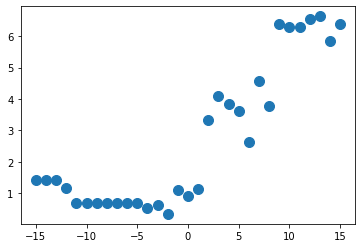

In [19]:
fig, ax = plt.subplots()
scat = ax.scatter(temp_oz['ChangeInTemperature'], temp_oz['O3Predmin'], s=100, marker='o')

plt.show()

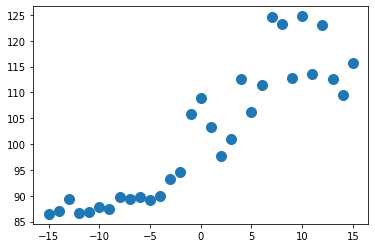

In [20]:
fig, ax = plt.subplots()
scat = ax.scatter(temp_oz['ChangeInTemperature'], temp_oz['O3Predmax'], s=100, marker='o')

plt.show()

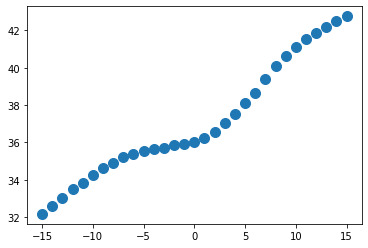

In [21]:
fig, ax = plt.subplots()
scat = ax.scatter(temp_oz['ChangeInTemperature'], temp_oz['O3Predmean'], s=100, marker='o')

plt.show()

In [22]:
incwind=[]
ozone_max=[]
for k,v in wind_only_ozone_max_dict.items():
    incwind.append(k)
    ozone_max.append(v)
wind_oz_max = pd.DataFrame.from_dict({'ChangeInWind':incwind, 'O3Predmax':ozone_max})

incwind=[]
ozone_min=[]
for k,v in wind_only_ozone_min_dict.items():
    incwind.append(k)
    ozone_min.append(v)
wind_oz_min = pd.DataFrame.from_dict({'ChangeInWind':incwind, 'O3Predmin':ozone_min})

incwind=[]
ozone_mean=[]
for k,v in wind_only_ozone_mean_dict.items():
    incwind.append(k)
    ozone_mean.append(v)
wind_oz_mean = pd.DataFrame.from_dict({'ChangeInWind':incwind, 'O3Predmean':ozone_mean})


wind_oz = wind_oz_min.merge(wind_oz_max, how='left', on='ChangeInWind')
wind_oz = wind_oz.merge(wind_oz_mean, how='left', on='ChangeInWind')

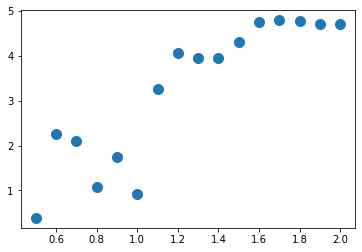

In [23]:
fig, ax = plt.subplots()
scat = ax.scatter(wind_oz['ChangeInWind'], wind_oz['O3Predmin'], s=100, marker='o')

plt.show()

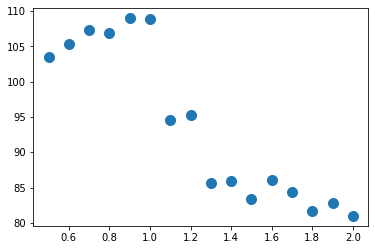

In [24]:
fig, ax = plt.subplots()
scat = ax.scatter(wind_oz['ChangeInWind'], wind_oz['O3Predmax'], s=100, marker='o')

plt.show()

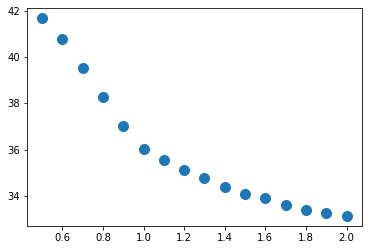

In [25]:
fig, ax = plt.subplots()
scat = ax.scatter(wind_oz['ChangeInWind'], wind_oz['O3Predmean'], s=100, marker='o')

plt.show()

In [26]:
incrain=[]
ozone_max=[]
for k,v in rain_only_ozone_max_dict.items():
    incrain.append(k)
    ozone_max.append(v)
rain_oz_max = pd.DataFrame.from_dict({'ChangeInRainPrcp':incrain, 'O3Predmax':ozone_max})

incrain=[]
ozone_min=[]
for k,v in rain_only_ozone_min_dict.items():
    incrain.append(k)
    ozone_min.append(v)
rain_oz_min = pd.DataFrame.from_dict({'ChangeInRainPrcp':incrain, 'O3Predmin':ozone_min})

incrain=[]
ozone_mean=[]
for k,v in rain_only_ozone_mean_dict.items():
    incrain.append(k)
    ozone_mean.append(v)
rain_oz_mean = pd.DataFrame.from_dict({'ChangeInRainPrcp':incrain, 'O3Predmean':ozone_mean})


rain_oz = rain_oz_min.merge(rain_oz_max, how='left', on='ChangeInRainPrcp')
rain_oz = rain_oz.merge(rain_oz_mean, how='left', on='ChangeInRainPrcp')

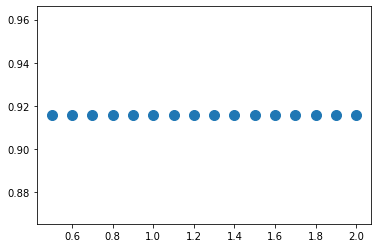

In [27]:
fig, ax = plt.subplots()
scat = ax.scatter(rain_oz['ChangeInRainPrcp'], rain_oz['O3Predmin'], s=100, marker='o')

plt.show()

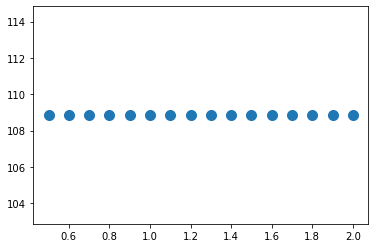

In [28]:
fig, ax = plt.subplots()
scat = ax.scatter(rain_oz['ChangeInRainPrcp'], rain_oz['O3Predmax'], s=100, marker='o')

plt.show()

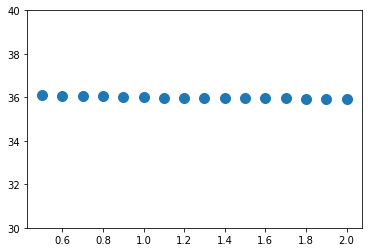

In [40]:
fig, ax = plt.subplots()
scat = ax.scatter(rain_oz['ChangeInRainPrcp'], rain_oz['O3Predmean'], s=100, marker='o')
ax.set_ylim(30,40)
sns.de
plt.show()

In [30]:
# time for mayhem... or not
# decrease and increasse of temperature that will be added to the test data
increase_temp = [-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

# the wind will decrease down to 50% or increase up to the double of the test data
increase_wind = [0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]

temp_list=[]
wind_list=[]
ozone_max=[]
ozone_min=[]
ozone_mean=[]


for inctemp in increase_temp:
    for incwind in increase_wind:
        X_ozone_mayhem = X_ozone_test.copy()
        X_ozone_mayhem['temp_max'] = X_ozone_mayhem['temp_max']+inctemp
        X_ozone_mayhem['wind_avgspeed'] = X_ozone_mayhem['wind_avgspeed']*incwind
        X_ozone_mayhem['wind_fastest_2min'] = X_ozone_mayhem['wind_fastest_2min']*incwind
        predicted_mayhem = aqh_model.predict(X_ozone_mayhem)
        temp_list.append(inctemp)
        wind_list.append(incwind)
        ozone_max.append(predicted_mayhem.max())
        ozone_min.append(predicted_mayhem.min())
        ozone_mean.append(predicted_mayhem.mean())
df = pd.DataFrame.from_dict({'ChangeInTemperature':temp_list, 'ChangeInWind':wind_list, 'O3Predmin':ozone_min,
                            'O3Predmax':ozone_max,'O3Predmean':ozone_mean})
df

,ChangeInTemperature,ChangeInWind,O3Predmin,O3Predmax,O3Predmean
0,-15,0.5,2.713149,91.025322,32.643906
1,-15,0.6,2.492870,94.298622,32.641193
2,-15,0.7,0.840171,89.455986,32.542713
3,-15,0.8,3.424952,87.361656,32.386852
4,-15,0.9,3.632886,82.149826,32.201092
...,...,...,...,...,...
491,15,1.6,6.599469,102.234192,37.396999
492,15,1.7,5.817703,102.484451,36.853371
493,15,1.8,5.187969,94.762352,36.354317
494,15,1.9,6.111858,84.934402,36.122578


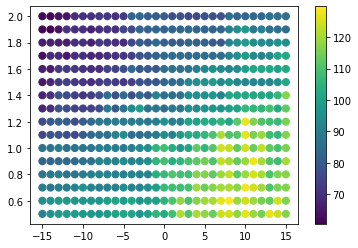

In [31]:
import numpy as np
import matplotlib.pyplot as plt


## generate a random data set


fig, ax = plt.subplots()
scat = ax.scatter(df['ChangeInTemperature'], df['ChangeInWind'],c=df['O3Predmax'], s=50, marker='o')
fig.colorbar(scat)

plt.show()


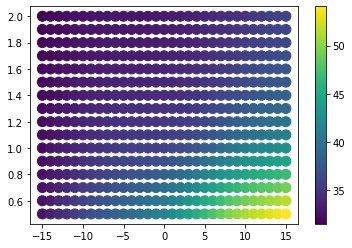

In [32]:
fig, ax = plt.subplots()
scat = ax.scatter(df['ChangeInTemperature'], df['ChangeInWind'],c=df['O3Predmean'], s=100, marker='o')
fig.colorbar(scat)

plt.show()


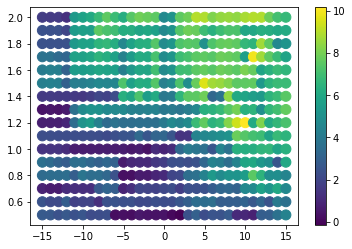

In [33]:
fig, ax = plt.subplots()
scat = ax.scatter(df['ChangeInTemperature'], df['ChangeInWind'],c=df['O3Predmin'], s=100, marker='o')
fig.colorbar(scat)

plt.show()


Let's look at the same pprediction but this time using AQI labels.

In [34]:
def aqi_cats(dataframe,colpoll):
    aqiwiki={ 'aqi' : [(0,50),(51,100),(101,150),(151,200),(201,300)],
              'poll' : {'ozone' : [(0.0, 55.0),
                                (55.0, 70.0),
                                (70.0, 85.0),
                                (85.0, 105.0),
                                (105.0, 200.0)],
                        'co': [(0.0, 4.5),
                                (4.5, 9.5),
                                (9.5, 12.5),
                                (12.5, 15.5),
                                (15.5, 30.5)],
                         'no2': [(0.0, 55.0),
                                (55.0, 100.0),
                                (100.0, 360.0),
                                (360.0, 650.0),
                                (650.0, 1250.0)],  
                        'so2': [(0.0, 35.0),
                                (35.0, 75.0),
                                (75.0, 185.0),
                                (185.0, 305.0),
                                (305.0, 605.0)],
                         'pm25': [(0.0, 12.0),
                                (12.0, 35.5),
                                (35.5, 55.5),
                                (55.5, 150.5),
                                (150.5, 250.5)],
                        'pm10': [(0.0, 55.0),
                                (55.0, 155.0),
                                (155.0, 255.0),
                                (255.0, 355.0),
                                (355.0, 425.2)]},
            'aqi_cat' :['no emission','safe','moderate','unhealthy for sensitive groups','unhealthy','very unhealthy']}
    df=dataframe
    aqiwiki_brkpts=aqiwiki['poll'][colpoll]
    aqiwiki_labels=aqiwiki['aqi_cat']
    colname='aqi_'+colpoll
    df[colname]= np.where(df[colpoll]<aqiwiki_brkpts[0][1],aqiwiki_labels[1],
                                      (np.where(df[colpoll]<aqiwiki_brkpts[1][1],aqiwiki_labels[2],
                                      (np.where(df[colpoll]<aqiwiki_brkpts[2][1],aqiwiki_labels[3],
                                      (np.where(df[colpoll]<aqiwiki_brkpts[3][1],aqiwiki_labels[4],aqiwiki_labels[5])))))))
    return df

In [35]:
# convert ozone values to AQI labels
df_min=df.copy()
df_min['ozone'] = df_min['O3Predmin']
aqi_cats(df_min,'ozone')

df_max=df.copy()
df_max['ozone'] = df_max['O3Predmax']
aqi_cats(df_max,'ozone')

df_mean=df.copy()
df_mean['ozone'] = df_mean['O3Predmean']
aqi_cats(df_mean,'ozone')

,ChangeInTemperature,ChangeInWind,O3Predmin,O3Predmax,O3Predmean,ozone,aqi_ozone
0,-15,0.5,2.713149,91.025322,32.643906,32.643906,safe
1,-15,0.6,2.492870,94.298622,32.641193,32.641193,safe
2,-15,0.7,0.840171,89.455986,32.542713,32.542713,safe
3,-15,0.8,3.424952,87.361656,32.386852,32.386852,safe
4,-15,0.9,3.632886,82.149826,32.201092,32.201092,safe
...,...,...,...,...,...,...,...
491,15,1.6,6.599469,102.234192,37.396999,37.396999,safe
492,15,1.7,5.817703,102.484451,36.853371,36.853371,safe
493,15,1.8,5.187969,94.762352,36.354317,36.354317,safe
494,15,1.9,6.111858,84.934402,36.122578,36.122578,safe


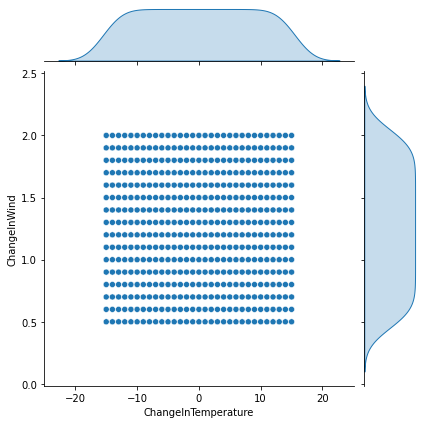

In [36]:
p = sns.jointplot(data=df_mean, x="ChangeInTemperature", y="ChangeInWind", hue="aqi_ozone", legend=False)

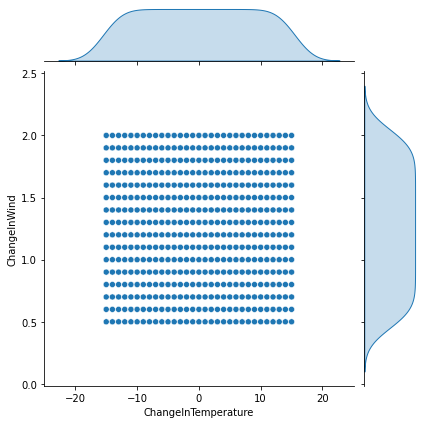

In [37]:
p = sns.jointplot(data=df_min, x="ChangeInTemperature", y="ChangeInWind", hue="aqi_ozone", legend=False)


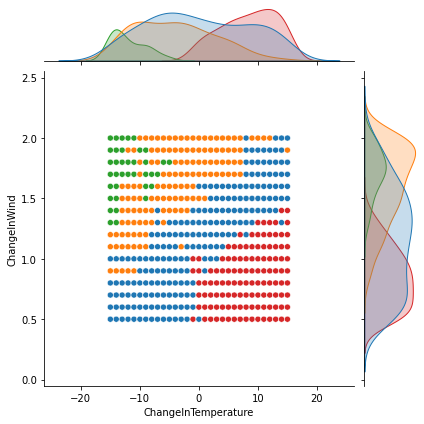

In [38]:
p = sns.jointplot(data=df_max, x="ChangeInTemperature", y="ChangeInWind", hue="aqi_ozone", legend=False)


<a class="anchor" id="section5_4"></a>
## 5.4. The Final Conclusion
I think it is very difficult for data scientists to avoid being biased by the data and their personal opinion or experience when preparing datasets to build a model. I am sure my bias came from the many hours during which I got stuck in traffic in Houston, the many hours of small talk about traffic, and the numerous and recurring news and headlines about traffic, haze, smog...etc... 
The data said "No".
The model said "Let me show you what it is about".
Using the XGB Regressor, the results could have been better if the data was just focussed on collecting pollutant, including VOCs, and weather data, skipping population and traffic. Even if the metrics of the model are not ideal or optimum, the model reveals interesting and somewhat releaving trends. 

It is a  relief to see the limited power of heat on ozone formation, in that more heat does not mean more ozone and therefore the source of "chemical ingredients" should be controlled. On the other hand the dual role of the wind which can either bring the ozone problem in Houston or push it away is much more interesting.
Forecasts for Houston predict more people, more traffic, more heat, more industrial activity... maybe Houston also needs more wind ;)